# **NYC Airbnb Data Analysis - 2019**
**Description: Comprehensive analysis of Airbnb listings in New York City**

# Import Libraries and Setup



In [ ]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins

# Statistical analysis
import scipy.stats as stats
from scipy.stats import f_oneway, shapiro

In [ ]:
# Configure plotting settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Display settings for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Data Loading and Initial Exploration
**Load the NYC Airbnb dataset and perform initial exploration**

In [ ]:
!unzip /content/AB_NYC_2019.csv.zip

data = pd.read_csv('/content/AB_NYC_2019.csv')
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\n" + "="*50)
print("First 5 rows:")
data.head()

Archive:  /content/AB_NYC_2019.csv.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AB_NYC_2019.csv         
Shape: (48895, 16)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

First 5 rows:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Data Information and Quality Assessment
**Comprehensive data quality assessment and missing value analysis**

In [ ]:
print("DATASET INFORMATION")
print("="*50)
data.info()

print("\n MISSING VALUES ANALYSIS")
print("="*50)
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage.round(2)
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if not missing_df.empty:
    print(missing_df)
else:
    print("No missing values found!")

print("\n CHECKING RELATIONSHIP BETWEEN MISSING VALUES")
print("="*50)
# Check if last_review and reviews_per_month have the same missing pattern
same_pattern = (data['last_review'].isnull() == data['reviews_per_month'].isnull()).all()
print(f"last_review and reviews_per_month have same missing pattern: {same_pattern}")


DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review 

# Data Cleaning and Preprocessing

Clean the data by handling missing values and removing unnecessary columns

In [ ]:
print("DATA CLEANING PROCESS")
print("="*50)

# Create a copy for cleaning
data_clean = data.copy()

# Handle missing values in reviews_per_month
# Logic: If no reviews, then reviews_per_month should be 0
print("Before cleaning - reviews_per_month null count:", data_clean['reviews_per_month'].isnull().sum())
data_clean.loc[data_clean['reviews_per_month'].isnull(), 'reviews_per_month'] = 0
print("After cleaning - reviews_per_month null count:", data_clean['reviews_per_month'].isnull().sum())

# Remove columns that are not needed for analysis
columns_to_drop = ['id', 'name', 'host_name', 'last_review']
print(f"\nDropping columns: {columns_to_drop}")
data_clean.drop(columns_to_drop, axis=1, inplace=True)

print(f"\nCleaned dataset shape: {data_clean.shape}")
print("Remaining missing values:")
print(data_clean.isnull().sum().sum())

DATA CLEANING PROCESS
Before cleaning - reviews_per_month null count: 10052
After cleaning - reviews_per_month null count: 0

Dropping columns: ['id', 'name', 'host_name', 'last_review']

Cleaned dataset shape: (48895, 12)
Remaining missing values:
0


# Statistical Summary and Data Filtering

**Generate statistical summary and apply business logic filters**

In [ ]:
print("STATISTICAL SUMMARY")
print("="*50)
print(data_clean.describe())

print(f"\n APPLYING BUSINESS LOGIC FILTERS")
print("="*50)

# Filter 1: Remove listings with price = 0 (likely errors or free stays)
print(f"Original dataset: {len(data_clean):,} records")

data_filtered = data_clean[data_clean['price'] > 0].copy()
print(f"After removing price = 0: {len(data_filtered):,} records")
print(f"Removed {len(data_clean) - len(data_filtered):,} records with zero price")

# Filter 2: Remove unrealistic minimum_nights (> 365 days)
data_filtered = data_filtered[data_filtered['minimum_nights'] <= 365].copy()
print(f"After removing minimum_nights > 365: {len(data_filtered):,} records")

print(f"\n Final filtered dataset: {len(data_filtered):,} records")

STATISTICAL SUMMARY
            host_id      latitude     longitude         price  minimum_nights  number_of_reviews  reviews_per_month  calculated_host_listings_count  availability_365
count  4.889500e+04  48895.000000  48895.000000  48895.000000    48895.000000       48895.000000       48895.000000                    48895.000000      48895.000000
mean   6.762001e+07     40.728949    -73.952170    152.720687        7.029962          23.274466           1.090910                        7.143982        112.781327
std    7.861097e+07      0.054530      0.046157    240.154170       20.510550          44.550582           1.597283                       32.952519        131.622289
min    2.438000e+03     40.499790    -74.244420      0.000000        1.000000           0.000000           0.000000                        1.000000          0.000000
25%    7.822033e+06     40.690100    -73.983070     69.000000        1.000000           1.000000           0.040000                        1.000000   

# Host Analysis - Top Hosts by Listings
Analyze host behavior and identify top-performing hosts

In [ ]:
print("HOST ANALYSIS")
print("="*50)

# Top hosts by number of listings
top_hosts = data_filtered['host_id'].value_counts().head(10)
print("Top 10 hosts by number of listings:")
print(top_hosts)

# Analyze a specific top host in detail
top_host_id = top_hosts.index[0]
host_listings = data_filtered[data_filtered['host_id'] == top_host_id].copy()

print(f"\n Detailed analysis of Host ID: {top_host_id}")
print(f"Total listings: {len(host_listings)}")
print("\n Borough distribution:")
print(host_listings['neighbourhood_group'].value_counts())
print(f"\n Price statistics:")
print(host_listings['price'].describe())

# Compare with overall market
print(f"\n Comparison with overall market:")
print(f"Host average price: ${host_listings['price'].mean():.2f}")
print(f"Market average price: ${data_filtered['price'].mean():.2f}")

HOST ANALYSIS
Top 10 hosts by number of listings:
host_id
219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
16098958      96
61391963      91
22541573      87
200380610     65
1475015       52
Name: count, dtype: int64

 Detailed analysis of Host ID: 219517861
Total listings: 327

 Borough distribution:
neighbourhood_group
Manhattan    327
Name: count, dtype: int64

 Price statistics:
count    327.000000
mean     253.195719
std      119.586884
min      100.000000
25%      188.500000
50%      228.000000
75%      255.000000
max      699.000000
Name: price, dtype: float64

 Comparison with overall market:
Host average price: $253.20
Market average price: $152.76


# Outlier Detection and Removal
Detect and remove price outliers using IQR method

In [ ]:
print("OUTLIER DETECTION AND REMOVAL")
print("="*50)

# Calculate quartiles and IQR
Q1 = data_filtered['price'].quantile(0.25)
Q3 = data_filtered['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): ${Q1:.2f}")
print(f"Q3 (75th percentile): ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")

# Remove outliers
outliers_mask = (data_filtered['price'] < lower_bound) | (data_filtered['price'] > upper_bound)
n_outliers = outliers_mask.sum()

data_no_outliers = data_filtered[~outliers_mask].copy()

print(f"\nOutliers detected: {n_outliers:,}")
print(f"Percentage of outliers: {(n_outliers/len(data_filtered)*100):.2f}%")
print(f"Dataset after outlier removal: {len(data_no_outliers):,} records")

print("\nPrice statistics after outlier removal:")
print(data_no_outliers['price'].describe())

OUTLIER DETECTION AND REMOVAL
Q1 (25th percentile): $69.00
Q3 (75th percentile): $175.00
IQR: $106.00
Lower bound: $-90.00
Upper bound: $334.00

Outliers detected: 2,971
Percentage of outliers: 6.08%
Dataset after outlier removal: 45,899 records

Price statistics after outlier removal:
count    45899.000000
mean       119.999804
std         68.135132
min         10.000000
25%         65.000000
50%        100.000000
75%        159.000000
max        334.000000
Name: price, dtype: float64


# Price Distribution Analysis
Analyze and visualize the distribution of prices

 PRICE DISTRIBUTION ANALYSIS


/tmp/ipython-input-1563456898.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_outliers['price'], ax=axes[1,0], color='green', hist=True, kde=True)


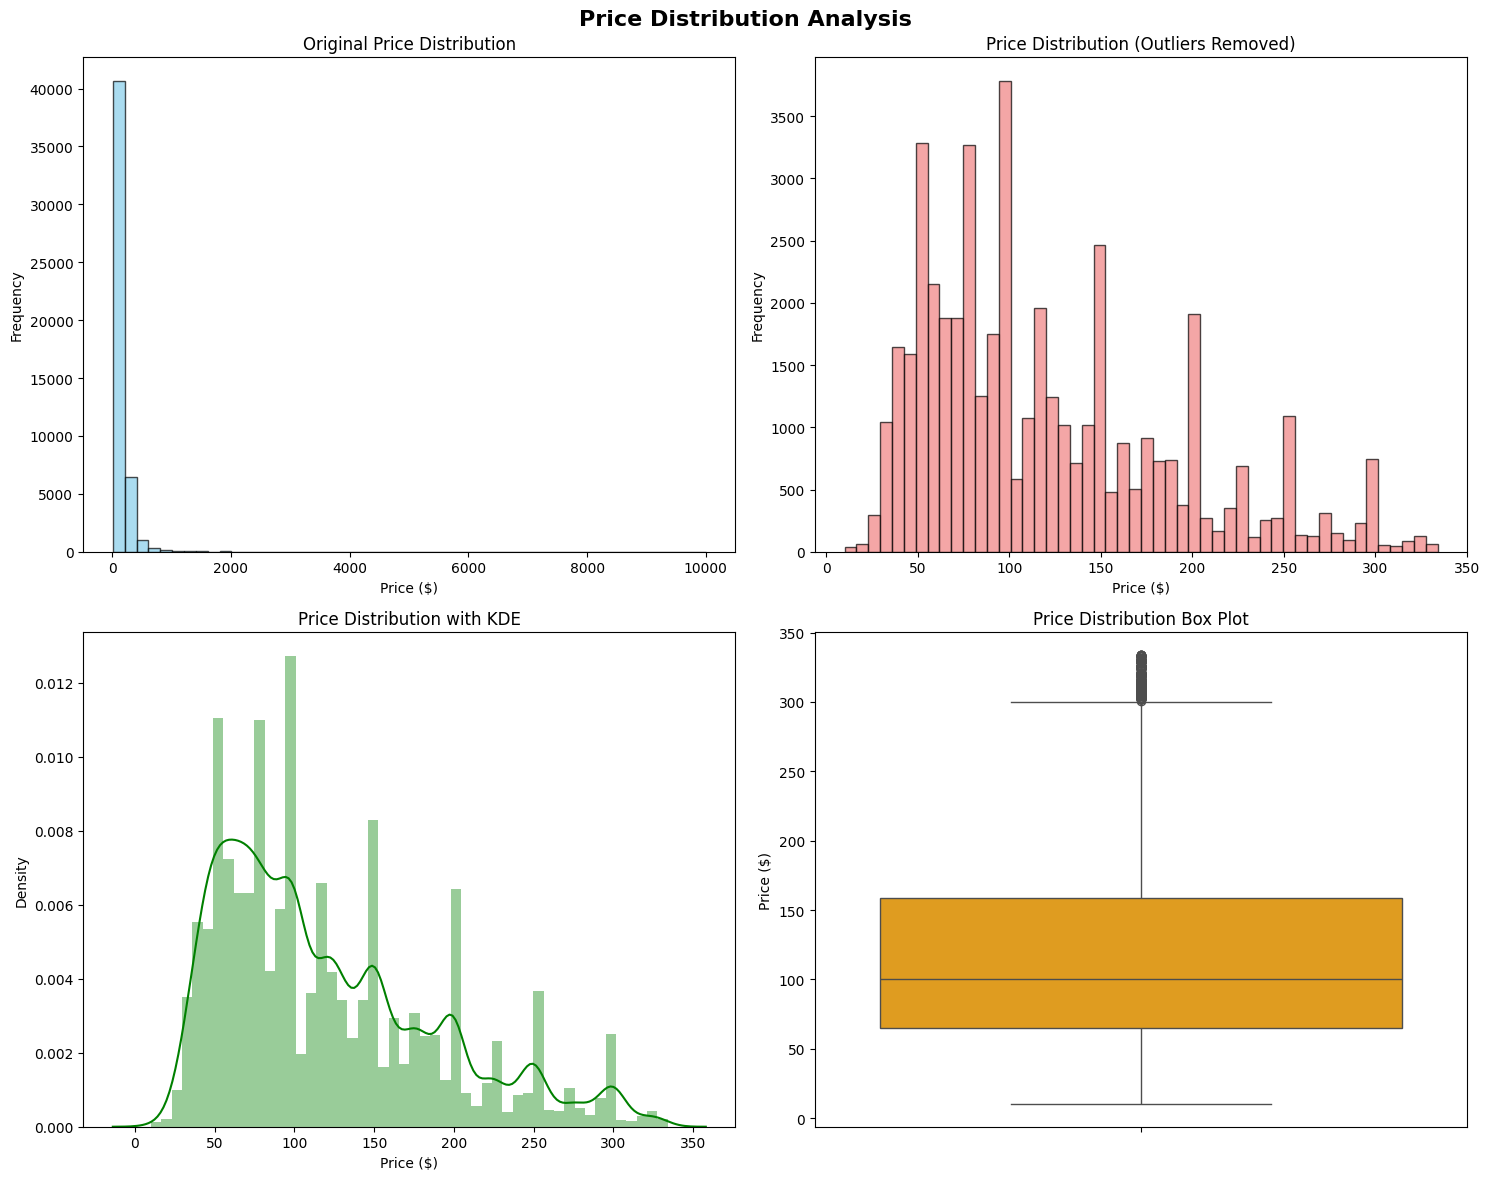


 Shapiro-Wilk Normality Test:
Test statistic: 0.916745
P-value: 3.55e-46
Interpretation: Not normal distribution


In [ ]:
print(" PRICE DISTRIBUTION ANALYSIS")
print("="*50)

# Create subplots for comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold')

# Original price distribution
axes[0,0].hist(data_filtered['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Original Price Distribution')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].set_ylabel('Frequency')

# Price distribution after outlier removal
axes[0,1].hist(data_no_outliers['price'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Price Distribution (Outliers Removed)')
axes[0,1].set_xlabel('Price ($)')
axes[0,1].set_ylabel('Frequency')

# Seaborn distribution plot
sns.distplot(data_no_outliers['price'], ax=axes[1,0], color='green', hist=True, kde=True)
axes[1,0].set_title('Price Distribution with KDE')
axes[1,0].set_xlabel('Price ($)')

# Box plot
sns.boxplot(data=data_no_outliers, y='price', ax=axes[1,1], color='orange')
axes[1,1].set_title('Price Distribution Box Plot')
axes[1,1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

# Test for normality
shapiro_stat, shapiro_p = shapiro(data_no_outliers['price'].sample(5000))  # Sample for performance
print(f"\n Shapiro-Wilk Normality Test:")
print(f"Test statistic: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.2e}")
print(f"Interpretation: {'Normal distribution' if shapiro_p > 0.05 else 'Not normal distribution'}")

# Geographic Analysis - Borough Overview
Analyze price patterns across different NYC boroughs

GEOGRAPHIC ANALYSIS - BOROUGHS
Price statistics by borough:
                       count    mean    std   min   25%    50%    75%    max
neighbourhood_group                                                         
Bronx                 1069.0   77.44  47.07  10.0  45.0   65.0   95.0  325.0
Brooklyn             19400.0  105.76  60.91  10.0  60.0   90.0  140.0  333.0
Manhattan            19500.0  145.96  70.47  10.0  90.0  135.0  199.0  334.0
Queens                5565.0   88.88  53.52  10.0  50.0   73.0  108.0  325.0
Staten Island          365.0   89.24  57.70  13.0  50.0   75.0  105.0  300.0

Listing distribution by borough:
Manhattan: 19,500 listings (42.5%)
Brooklyn: 19,400 listings (42.3%)
Queens: 5,565 listings (12.1%)
Bronx: 1,069 listings (2.3%)
Staten Island: 365 listings (0.8%)


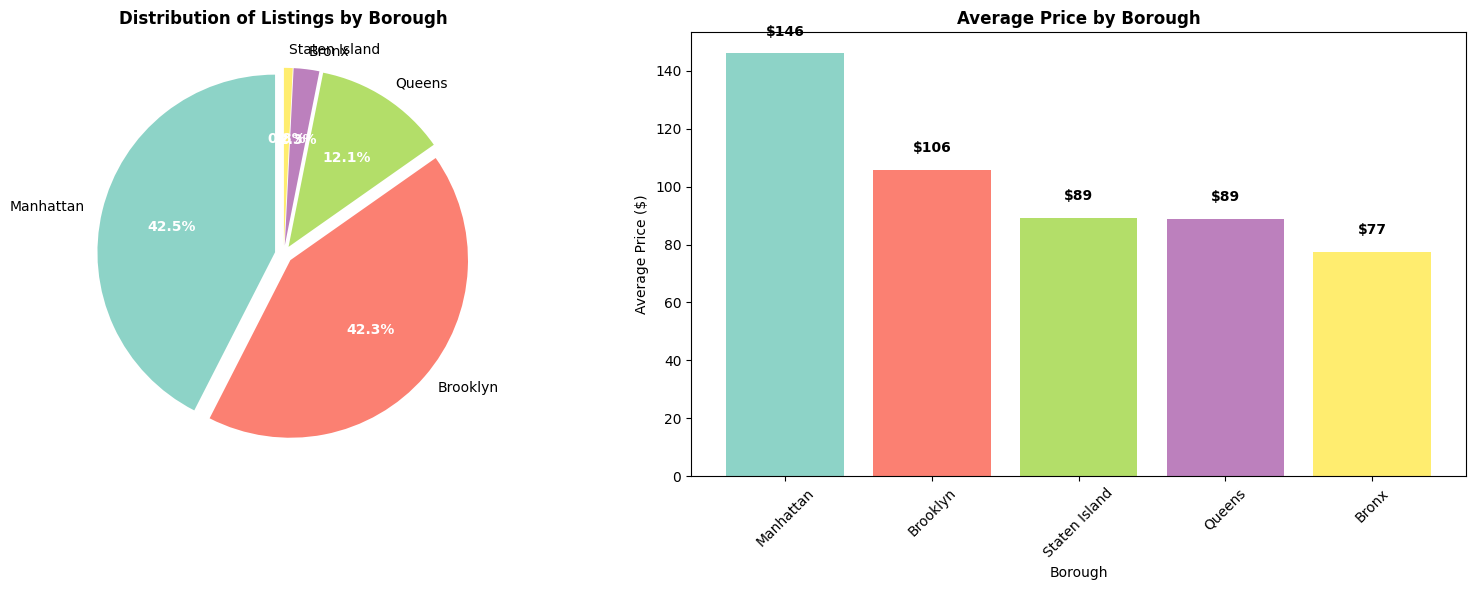

In [ ]:
print("GEOGRAPHIC ANALYSIS - BOROUGHS")
print("="*50)

# Borough price statistics
borough_stats = data_no_outliers.groupby('neighbourhood_group')['price'].describe()
print("Price statistics by borough:")
print(borough_stats.round(2))

# Borough distribution
borough_counts = data_no_outliers['neighbourhood_group'].value_counts()
print(f"\nListing distribution by borough:")
for borough, count in borough_counts.items():
    percentage = (count / len(data_no_outliers)) * 100
    print(f"{borough}: {count:,} listings ({percentage:.1f}%)")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart of borough distribution
colors = plt.cm.Set3(np.linspace(0, 1, len(borough_counts)))
wedges, texts, autotexts = axes[0].pie(borough_counts.values,
                                       labels=borough_counts.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=colors,
                                       explode=(0.05, 0.05, 0.05, 0.05, 0.05))
axes[0].set_title('Distribution of Listings by Borough', fontweight='bold')

# Enhance pie chart appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Bar plot of average prices
avg_prices = data_no_outliers.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
bars = axes[1].bar(avg_prices.index, avg_prices.values, color=colors[:len(avg_prices)])
axes[1].set_title('Average Price by Borough', fontweight='bold')
axes[1].set_ylabel('Average Price ($)')
axes[1].set_xlabel('Borough')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, value in zip(bars, avg_prices.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'${value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Interactive Heat Map of Listings
Create an interactive heat map showing the geographic distribution of listings


In [ ]:
print("CREATING INTERACTIVE HEAT MAP")
print("="*50)

# Create base map centered on NYC
ny_map = folium.Map(
    location=[40.7589, -73.9851],  # NYC coordinates
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Prepare location data
locations = data_no_outliers[['latitude', 'longitude']].values.tolist()

# Create and add heat map
heat_map = plugins.HeatMap(
    locations,
    min_opacity=0.2,
    max_zoom=18,
    radius=15,
    blur=10,
    gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
)

heat_map.add_to(ny_map)

# Add title
title_html = '''
<h3 align="center" style="font-size:16px"><b>NYC Airbnb Listings Heat Map - 2019</b></h3>
'''
ny_map.get_root().html.add_child(folium.Element(title_html))

print("Interactive heat map created!")
print("The map shows the concentration of Airbnb listings across NYC")

# Display the map
ny_map

CREATING INTERACTIVE HEAT MAP
Interactive heat map created!
The map shows the concentration of Airbnb listings across NYC


# Room Type Analysis
Analyze different room types and their characteristics

ROOM TYPE ANALYSIS
Comprehensive room type statistics:
                 price                       number_of_reviews availability_365 minimum_nights
                 count    mean median    std              mean             mean           mean
room_type                                                                                     
Entire home/apt  22779  162.55  150.0  63.37             23.86           106.06           8.33
Private room     21985   79.05   70.0  41.16             24.40           109.95           5.19
Shared room       1135   59.35   45.0  42.79             16.91           162.75           5.61


/tmp/ipython-input-2666751641.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_no_outliers, x='room_type', ax=axes[0,0], palette='viridis')
/tmp/ipython-input-2666751641.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_no_outliers, x='room_type', y='price', ax=axes[1,0], palette='viridis')


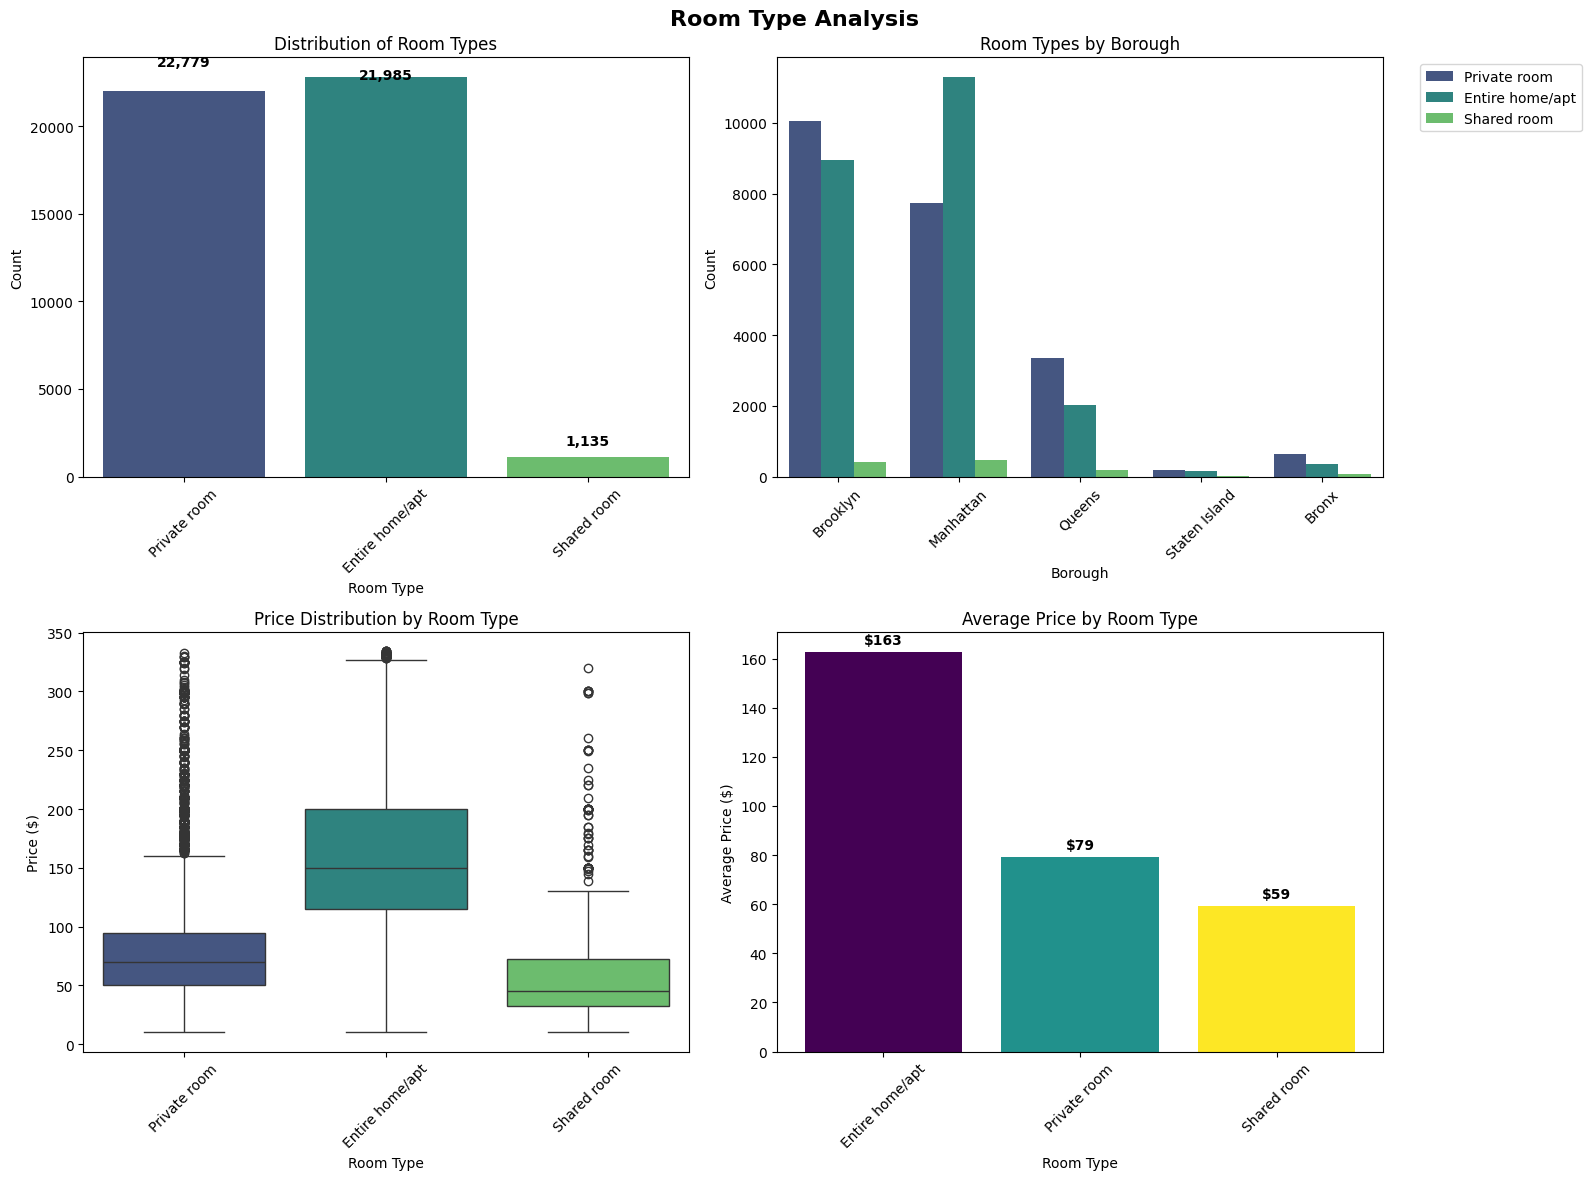

In [ ]:
print("ROOM TYPE ANALYSIS")
print("="*50)

# Room type distribution and statistics
room_type_stats = data_no_outliers.groupby('room_type').agg({
    'price': ['count', 'mean', 'median', 'std'],
    'number_of_reviews': 'mean',
    'availability_365': 'mean',
    'minimum_nights': 'mean'
}).round(2)

print("Comprehensive room type statistics:")
print(room_type_stats)

# Create comprehensive room type visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Room Type Analysis', fontsize=16, fontweight='bold')

# Room type count
room_counts = data_no_outliers['room_type'].value_counts()
sns.countplot(data=data_no_outliers, x='room_type', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribution of Room Types')
axes[0,0].set_xlabel('Room Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Add count labels
for i, (room_type, count) in enumerate(room_counts.items()):
    axes[0,0].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Room type by borough
sns.countplot(data=data_no_outliers, x='neighbourhood_group', hue='room_type', ax=axes[0,1], palette='viridis')
axes[0,1].set_title('Room Types by Borough')
axes[0,1].set_xlabel('Borough')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Price comparison by room type
sns.boxplot(data=data_no_outliers, x='room_type', y='price', ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Price Distribution by Room Type')
axes[1,0].set_xlabel('Room Type')
axes[1,0].set_ylabel('Price ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average price bar chart
avg_prices_room = data_no_outliers.groupby('room_type')['price'].mean().sort_values(ascending=False)
bars = axes[1,1].bar(avg_prices_room.index, avg_prices_room.values, color=plt.cm.viridis(np.linspace(0, 1, len(avg_prices_room))))
axes[1,1].set_title('Average Price by Room Type')
axes[1,1].set_xlabel('Room Type')
axes[1,1].set_ylabel('Average Price ($)')
axes[1,1].tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, avg_prices_room.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                  f'${value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Availability and Minimum Nights Analysis
Analyze booking patterns through availability and minimum night requirements

AVAILABILITY AND BOOKING PATTERNS
Minimum nights statistics by borough:
                       count  mean    std  min  25%  50%  75%    max
neighbourhood_group                                                 
Bronx                 1069.0  4.60  15.79  1.0  1.0  2.0  3.0  365.0
Brooklyn             19400.0  5.85  13.87  1.0  2.0  3.0  5.0  365.0
Manhattan            19500.0  8.34  18.92  1.0  1.0  3.0  6.0  365.0
Queens                5565.0  4.90   9.83  1.0  1.0  2.0  3.0  210.0
Staten Island          365.0  4.82  19.93  1.0  1.0  2.0  3.0  365.0

Availability statistics by borough:
                       count    mean     std  min   25%    50%    75%    max
neighbourhood_group                                                         
Bronx                 1069.0  164.60  135.03  0.0  36.0  146.0  312.0  365.0
Brooklyn             19400.0   98.42  125.39  0.0   0.0   26.0  185.0  365.0
Manhattan            19500.0  105.84  130.36  0.0   0.0   29.0  213.0  365.0
Queens                5

/tmp/ipython-input-3380257847.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_no_outliers, x='neighbourhood_group', y='minimum_nights', ax=axes[0,0], palette='Set2')
/tmp/ipython-input-3380257847.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_no_outliers, x='neighbourhood_group', y='availability_365', ax=axes[0,1], palette='Set2')


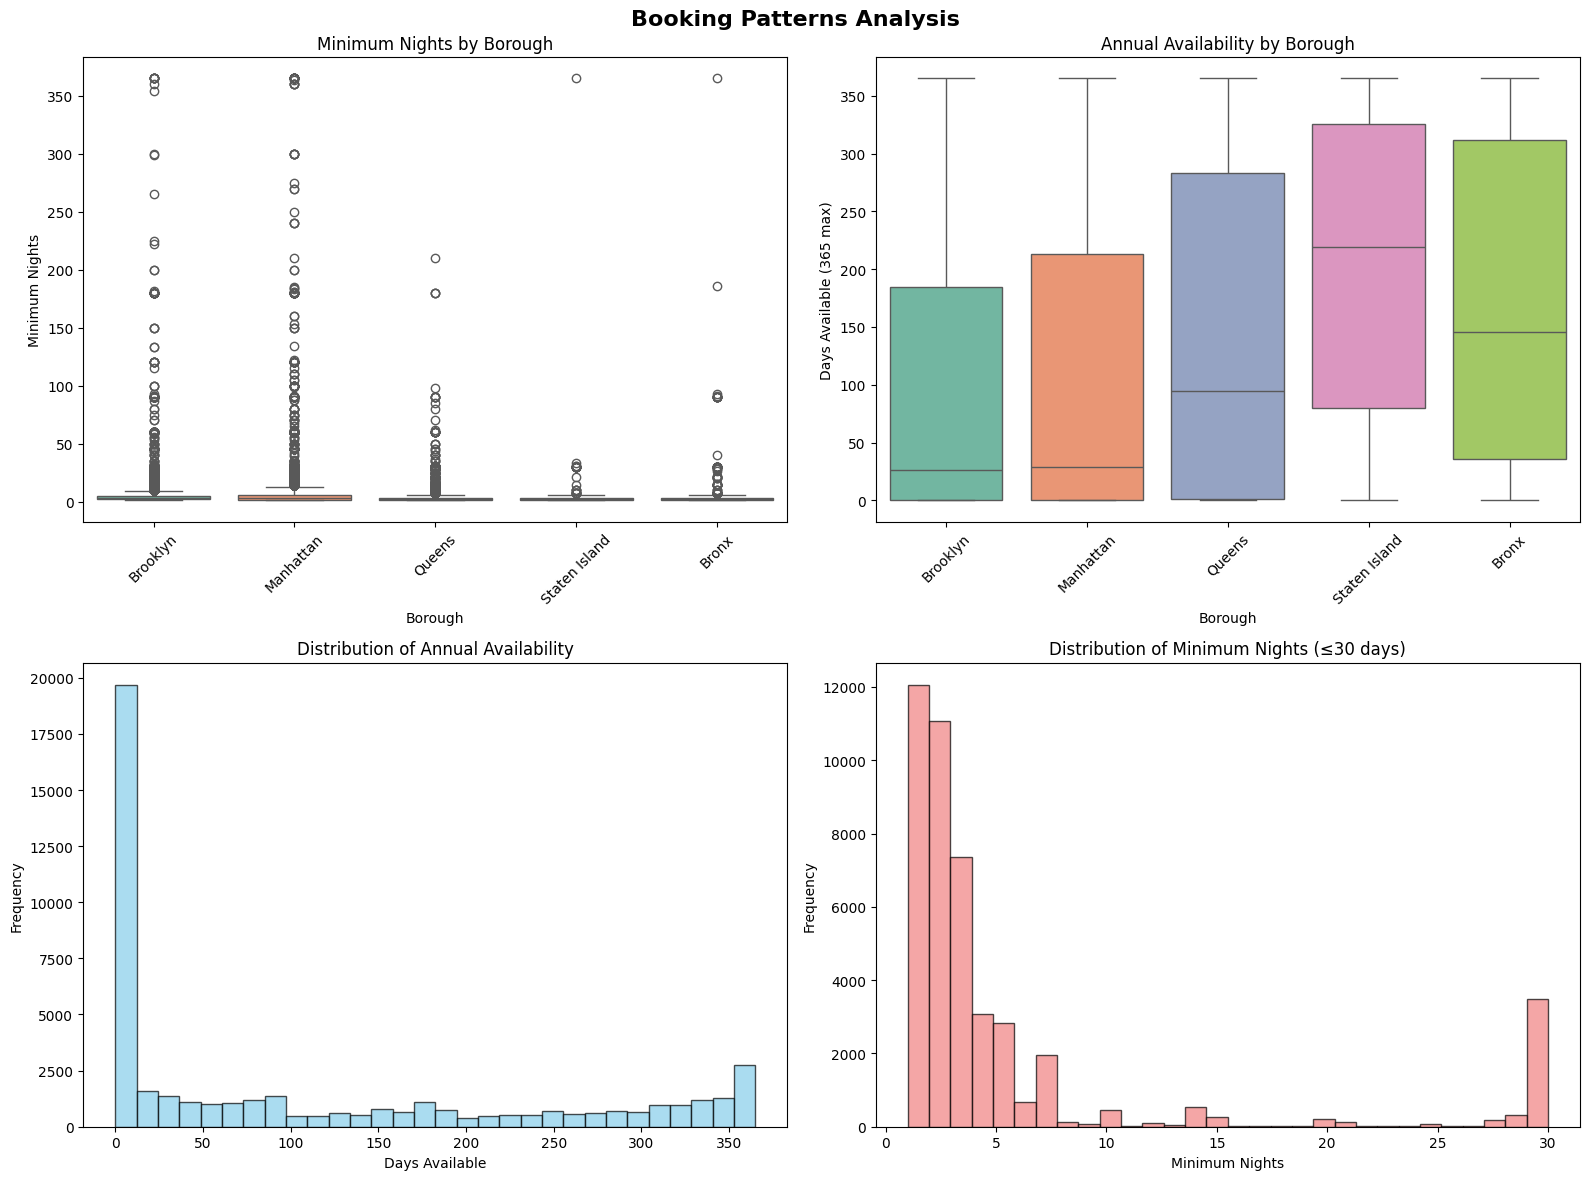

In [ ]:
print("AVAILABILITY AND BOOKING PATTERNS")
print("="*50)

# Minimum nights analysis by borough
min_nights_stats = data_no_outliers.groupby('neighbourhood_group')['minimum_nights'].describe()
print("Minimum nights statistics by borough:")
print(min_nights_stats.round(2))

# Availability analysis by borough
availability_stats = data_no_outliers.groupby('neighbourhood_group')['availability_365'].describe()
print("\nAvailability statistics by borough:")
print(availability_stats.round(2))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Booking Patterns Analysis', fontsize=16, fontweight='bold')

# Minimum nights by borough
sns.boxplot(data=data_no_outliers, x='neighbourhood_group', y='minimum_nights', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('Minimum Nights by Borough')
axes[0,0].set_xlabel('Borough')
axes[0,0].set_ylabel('Minimum Nights')
axes[0,0].tick_params(axis='x', rotation=45)

# Availability by borough
sns.boxplot(data=data_no_outliers, x='neighbourhood_group', y='availability_365', ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Annual Availability by Borough')
axes[0,1].set_xlabel('Borough')
axes[0,1].set_ylabel('Days Available (365 max)')
axes[0,1].tick_params(axis='x', rotation=45)

# Availability distribution
axes[1,0].hist(data_no_outliers['availability_365'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].set_title('Distribution of Annual Availability')
axes[1,0].set_xlabel('Days Available')
axes[1,0].set_ylabel('Frequency')

# Minimum nights distribution (limited to reasonable range)
reasonable_min_nights = data_no_outliers[data_no_outliers['minimum_nights'] <= 30]
axes[1,1].hist(reasonable_min_nights['minimum_nights'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].set_title('Distribution of Minimum Nights (≤30 days)')
axes[1,1].set_xlabel('Minimum Nights')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Price Analysis by Borough
Detailed price analysis across boroughs with visualizations

DETAILED PRICE ANALYSIS BY BOROUGH
Using 45,899 listings (price < $500) for visualization


/tmp/ipython-input-4144609259.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=price_viz_data, x='neighbourhood_group', y='price', ax=axes[0,0], palette='Set1')
/tmp/ipython-input-4144609259.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=price_viz_data, x='neighbourhood_group', y='price', ax=axes[0,1], palette='Set1')


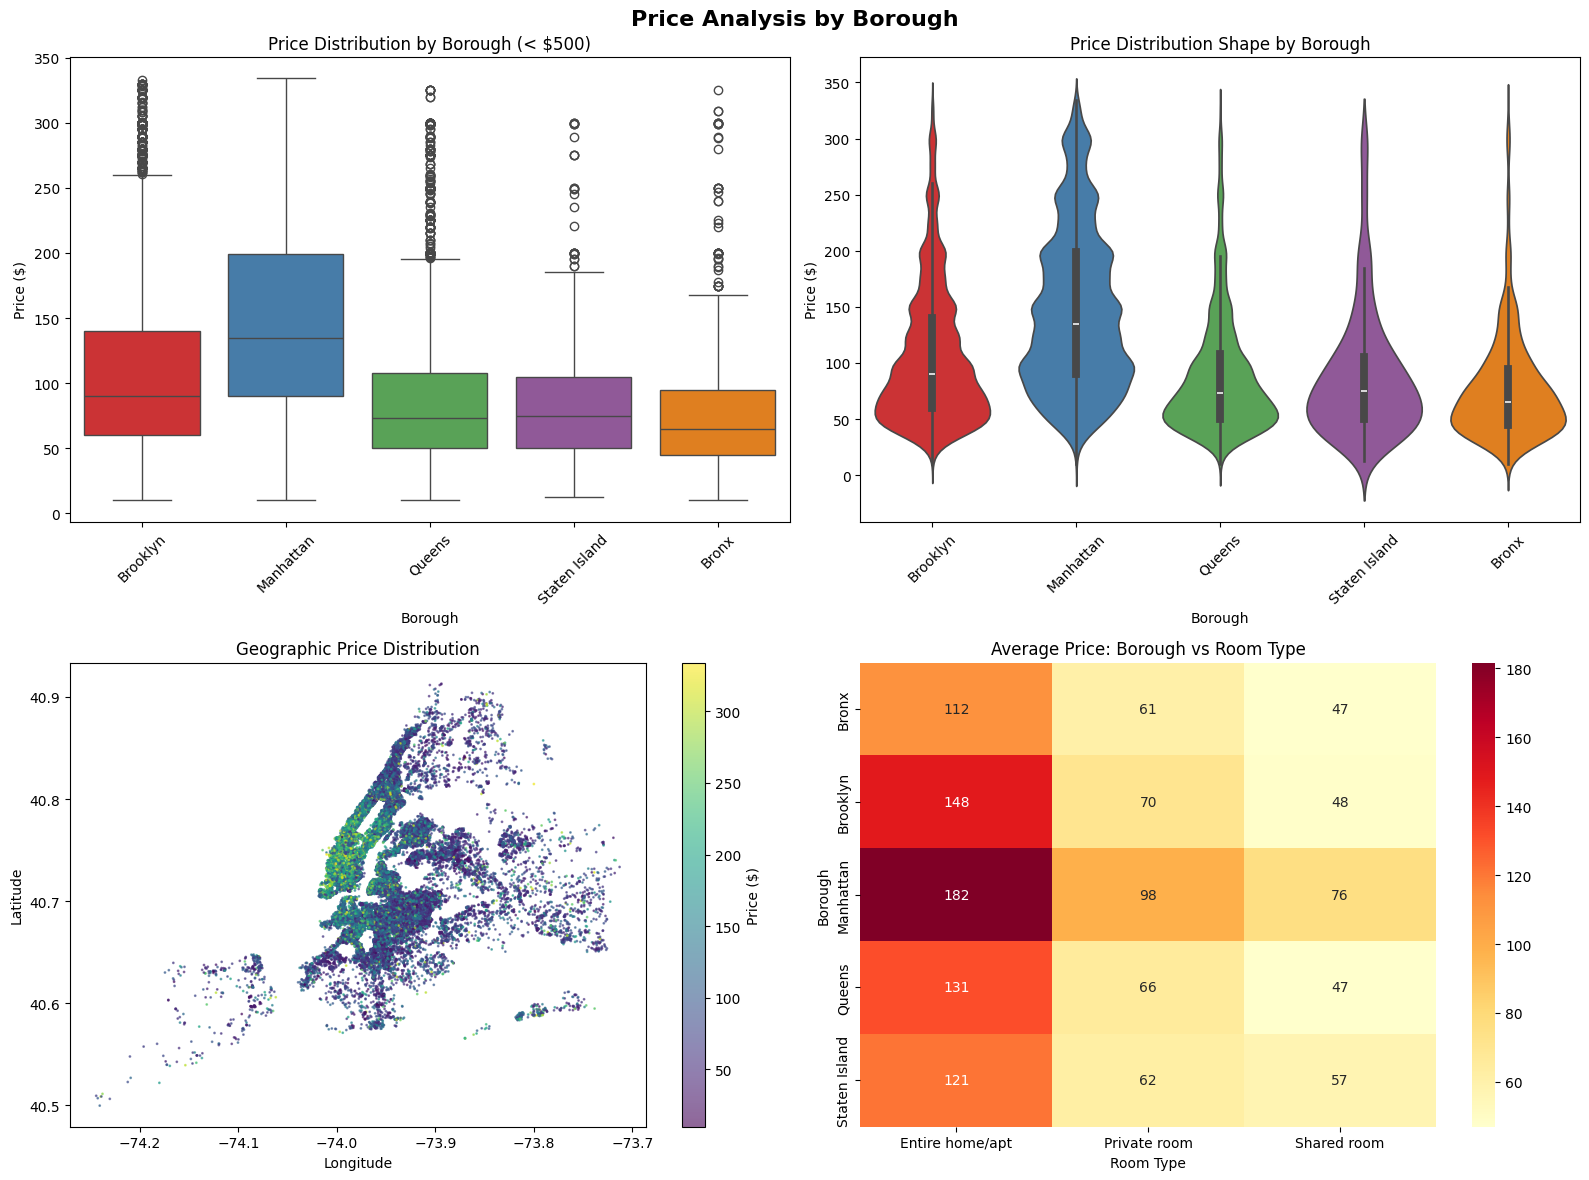

In [ ]:
print("DETAILED PRICE ANALYSIS BY BOROUGH")
print("="*50)

# Filter for better visualization (remove extreme outliers)
price_viz_data = data_no_outliers[data_no_outliers['price'] < 500].copy()
print(f"Using {len(price_viz_data):,} listings (price < $500) for visualization")

# Create comprehensive price visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Price Analysis by Borough', fontsize=16, fontweight='bold')

# Box plot of prices by borough
sns.boxplot(data=price_viz_data, x='neighbourhood_group', y='price', ax=axes[0,0], palette='Set1')
axes[0,0].set_title('Price Distribution by Borough (< $500)')
axes[0,0].set_xlabel('Borough')
axes[0,0].set_ylabel('Price ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Violin plot for distribution shape
sns.violinplot(data=price_viz_data, x='neighbourhood_group', y='price', ax=axes[0,1], palette='Set1')
axes[0,1].set_title('Price Distribution Shape by Borough')
axes[0,1].set_xlabel('Borough')
axes[0,1].set_ylabel('Price ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Scatter plot: Geography vs Price
scatter = axes[1,0].scatter(price_viz_data['longitude'], price_viz_data['latitude'],
                           c=price_viz_data['price'], cmap='viridis', alpha=0.6, s=1)
axes[1,0].set_title('Geographic Price Distribution')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[1,0], label='Price ($)')

# Average price by room type and borough
pivot_data = price_viz_data.groupby(['neighbourhood_group', 'room_type'])['price'].mean().unstack()
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1,1])
axes[1,1].set_title('Average Price: Borough vs Room Type')
axes[1,1].set_xlabel('Room Type')
axes[1,1].set_ylabel('Borough')

plt.tight_layout()
plt.show()

# Statistical Hypothesis Testing
Perform statistical tests to validate insights about pricing and availability

In [ ]:
print("STATISTICAL HYPOTHESIS TESTING")
print("="*50)

# Test 1: ANOVA - Are there significant price differences between boroughs?
print(" Test 1: One-way ANOVA for price differences between boroughs")
print("-" * 60)

borough_prices = [data_no_outliers[data_no_outliers['neighbourhood_group'] == borough]['price'].values
                 for borough in data_no_outliers['neighbourhood_group'].unique()]

f_stat, p_value = f_oneway(*borough_prices)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Result: {'Significant' if p_value < 0.05 else 'Not significant'} difference between boroughs")

# Test 2: Compare busiest listings (availability = 0) vs others
print(f"\n Test 2: T-test comparing fully booked vs available listings")
print("-" * 60)

fully_booked = data_no_outliers[data_no_outliers['availability_365'] == 0]
available = data_no_outliers[data_no_outliers['availability_365'] > 0]

print(f"Fully booked listings: {len(fully_booked):,}")
print(f"Available listings: {len(available):,}")

# Price comparison
t_stat_price, p_val_price = stats.ttest_ind(fully_booked['price'], available['price'])
print(f"\nPrice comparison:")
print(f"Fully booked average: ${fully_booked['price'].mean():.2f}")
print(f"Available average: ${available['price'].mean():.2f}")
print(f"T-statistic: {t_stat_price:.4f}, P-value: {p_val_price:.4f}")

# Test 3: Compare high-availability vs low-availability listings
print(f"\n Test 3: Comparing high vs low availability listings")
print("-" * 60)

low_availability = data_no_outliers[data_no_outliers['availability_365'] < 50]
high_availability = data_no_outliers[data_no_outliers['availability_365'] >= 300]

print(f"Low availability (<50 days): {len(low_availability):,}")
print(f"High availability (≥300 days): {len(high_availability):,}")

# Sample for fair comparison if needed
sample_size = min(len(low_availability), len(high_availability), 1000)
low_sample = low_availability.sample(n=sample_size, random_state=42)
high_sample = high_availability.sample(n=sample_size, random_state=42)

# Compare host listings count
t_stat_host, p_val_host = stats.ttest_ind(low_sample['calculated_host_listings_count'],
                                         high_sample['calculated_host_listings_count'])
print(f"\nHost listings count comparison:")
print(f"Low availability avg host listings: {low_sample['calculated_host_listings_count'].mean():.2f}")
print(f"High availability avg host listings: {high_sample['calculated_host_listings_count'].mean():.2f}")
print(f"T-statistic: {t_stat_host:.4f}, P-value: {p_val_host:.4f}")

# Compare minimum nights
t_stat_min, p_val_min = stats.ttest_ind(low_sample['minimum_nights'], high_sample['minimum_nights'])
print(f"\nMinimum nights comparison:")
print(f"Low availability avg min nights: {low_sample['minimum_nights'].mean():.2f}")
print(f"High availability avg min nights: {high_sample['minimum_nights'].mean():.2f}")
print(f"T-statistic: {t_stat_min:.4f}, P-value: {p_val_min:.4f}")


STATISTICAL HYPOTHESIS TESTING
 Test 1: One-way ANOVA for price differences between boroughs
------------------------------------------------------------
F-statistic: 1507.9217
P-value: 0.00e+00
Result: Significant difference between boroughs

 Test 2: T-test comparing fully booked vs available listings
------------------------------------------------------------
Fully booked listings: 16,844
Available listings: 29,055

Price comparison:
Fully booked average: $114.48
Available average: $123.20
T-statistic: -13.2283, P-value: 0.0000

 Test 3: Comparing high vs low availability listings
------------------------------------------------------------
Low availability (<50 days): 23,828
High availability (≥300 days): 7,353

Host listings count comparison:
Low availability avg host listings: 1.74
High availability avg host listings: 20.87
T-statistic: -10.0438, P-value: 0.0000

Minimum nights comparison:
Low availability avg min nights: 4.62
High availability avg min nights: 11.74
T-statistic:

# Correlation Analysis
Analyze correlations between different variables


CORRELATION ANALYSIS
Pearson Correlation Matrix:
                                price  minimum_nights  number_of_reviews  reviews_per_month  calculated_host_listings_count  availability_365  latitude  longitude
price                           1.000           0.039             -0.028             -0.047                           0.174             0.067     0.069     -0.307
minimum_nights                  0.039           1.000             -0.098             -0.152                           0.168             0.167     0.030     -0.077
number_of_reviews              -0.028          -0.098              1.000              0.594                          -0.071             0.184    -0.012      0.054
reviews_per_month              -0.047          -0.152              0.594              1.000                          -0.051             0.172    -0.018      0.140
calculated_host_listings_count  0.174           0.168             -0.071             -0.051                           1.000             

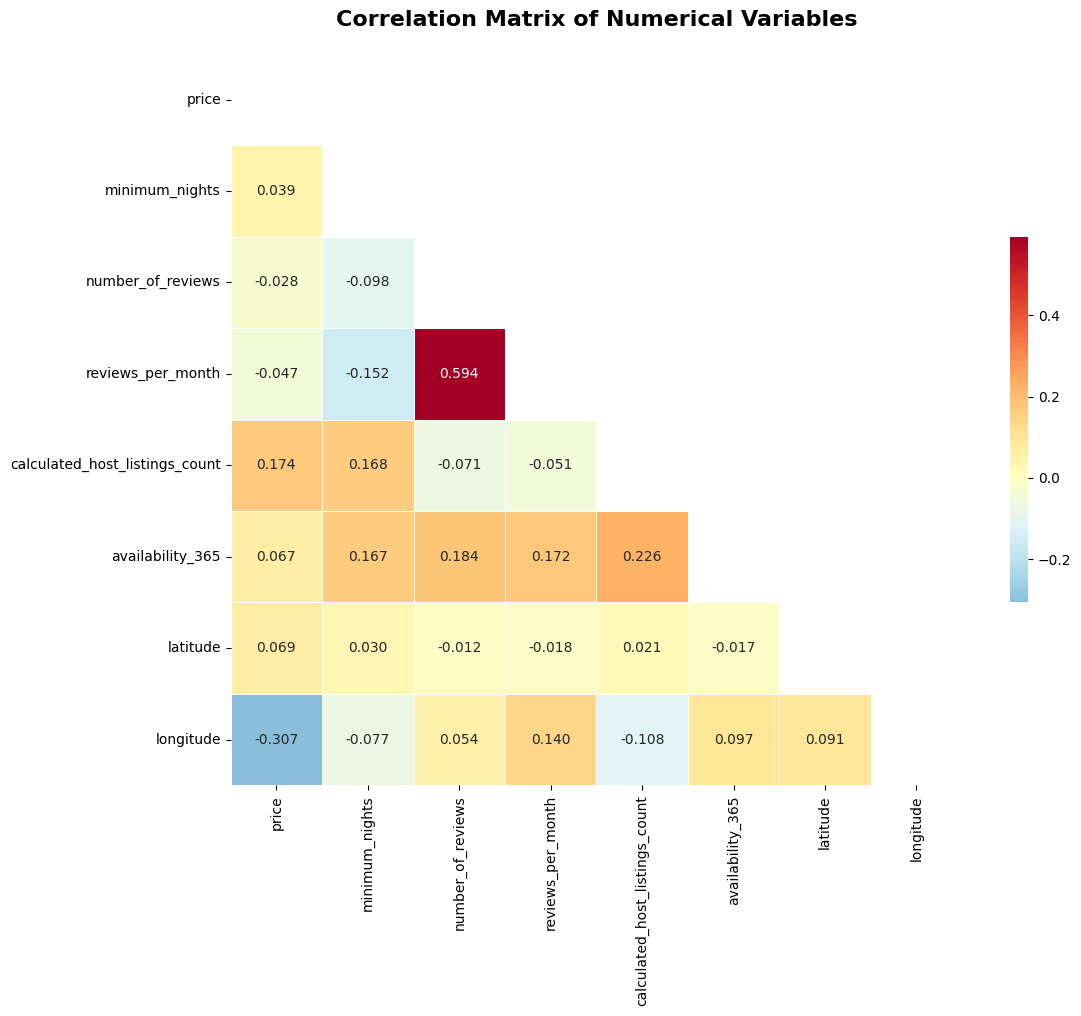


 STRONG CORRELATIONS (|r| > 0.3):
--------------------------------------------------
number_of_reviews ↔ reviews_per_month: 0.594 (positive)
price ↔ longitude: -0.307 (negative)


In [ ]:
print("CORRELATION ANALYSIS")
print("="*50)

# Select numerical columns for correlation
numerical_cols = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                 'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude']

# Calculate correlation matrix
correlation_matrix = data_no_outliers[numerical_cols].corr(method='pearson')

# Display correlation matrix
print("Pearson Correlation Matrix:")
print(correlation_matrix.round(3))

# Create enhanced correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(correlation_matrix,
           mask=mask,
           annot=True,
           cmap='RdYlBu_r',
           center=0,
           square=True,
           linewidths=0.5,
           cbar_kws={"shrink": 0.5},
           fmt='.3f')

plt.title('Correlation Matrix of Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify strong correlations
print(f"\n STRONG CORRELATIONS (|r| > 0.3):")
print("-" * 50)
strong_correlations = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            strong_correlations.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

for var1, var2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
    direction = "positive" if corr > 0 else "negative"
    print(f"{var1} ↔ {var2}: {corr:.3f} ({direction})")

# Advanced Insights and Business Intelligence
Generate actionable business insights from the analysis

In [ ]:
print("💡 BUSINESS INSIGHTS AND KEY FINDINGS")
print("="*70)

# 1. Top performing neighborhoods
print("TOP PERFORMING INSIGHTS")
print("-" * 40)

# Most expensive neighborhoods
neighborhood_prices = data_no_outliers.groupby('neighbourhood')['price'].agg(['mean', 'count']).reset_index()
neighborhood_prices = neighborhood_prices[neighborhood_prices['count'] >= 10]  # Min 10 listings
top_expensive = neighborhood_prices.nlargest(5, 'mean')

print("Top 5 most expensive neighborhoods (min 10 listings):")
for _, row in top_expensive.iterrows():
    print(f"• {row['neighbourhood']}: ${row['mean']:.0f} avg ({row['count']} listings)")

# 2. Host strategy analysis
print(f"\n HOST STRATEGY ANALYSIS")
print("-" * 40)

# Multi-listing hosts performance
multi_hosts = data_no_outliers[data_no_outliers['calculated_host_listings_count'] > 5]
single_hosts = data_no_outliers[data_no_outliers['calculated_host_listings_count'] == 1]

print(f"Multi-listing hosts (>5 properties): {len(multi_hosts):,} listings")
print(f"Single-listing hosts: {len(single_hosts):,} listings")
print(f"Multi-host avg price: ${multi_hosts['price'].mean():.2f}")
print(f"Single-host avg price: ${single_hosts['price'].mean():.2f}")
print(f"Multi-host avg availability: {multi_hosts['availability_365'].mean():.1f} days")
print(f"Single-host avg availability: {single_hosts['availability_365'].mean():.1f} days")

# 3. Pricing strategy insights
print(f"\n PRICING STRATEGY INSIGHTS")
print("-" * 40)

# Optimal price ranges by room type
for room_type in data_no_outliers['room_type'].unique():
    room_data = data_no_outliers[data_no_outliers['room_type'] == room_type]

    # Find sweet spot (highest occupancy rate proxy)
    price_bins = pd.cut(room_data['price'], bins=10)
    bin_analysis = room_data.groupby(price_bins).agg({
        'availability_365': 'mean',
        'number_of_reviews': 'mean',
        'price': ['count', 'mean']
    }).round(2)

    # Calculate occupancy proxy (lower availability = higher occupancy)
    occupancy_proxy = 365 - bin_analysis[('availability_365', 'mean')]
    best_occupancy_idx = occupancy_proxy.idxmax()

    print(f"\n{room_type}:")
    print(f"  • Optimal price range: {best_occupancy_idx}")
    print(f"  • Average occupancy in range: {occupancy_proxy.max():.0f} days/year")
    print(f"  • Average reviews in range: {bin_analysis.loc[best_occupancy_idx, ('number_of_reviews', 'mean')]}")

# 4. Market opportunity analysis
print(f"\n MARKET OPPORTUNITIES")
print("-" * 40)

# Under-served areas (high demand, low supply)
borough_demand = data_no_outliers.groupby('neighbourhood_group').agg({
    'price': 'mean',
    'availability_365': 'mean',
    'number_of_reviews': 'mean',
    'calculated_host_listings_count': 'count'
}).round(2)

borough_demand.columns = ['Avg_Price', 'Avg_Availability', 'Avg_Reviews', 'Total_Listings']
borough_demand['Occupancy_Rate'] = ((365 - borough_demand['Avg_Availability']) / 365 * 100).round(1)
borough_demand['Price_per_Review'] = (borough_demand['Avg_Price'] / borough_demand['Avg_Reviews']).round(2)

print("Borough performance metrics:")
print(borough_demand.sort_values('Occupancy_Rate', ascending=False))

# 5. Seasonal and demand patterns
print(f"\n DEMAND PATTERN INSIGHTS")
print("-" * 40)

# High-demand indicators
high_demand = data_no_outliers[
    (data_no_outliers['availability_365'] < 100) &
    (data_no_outliers['number_of_reviews'] > data_no_outliers['number_of_reviews'].median())
]

print(f"High-demand listings (low availability + high reviews): {len(high_demand):,}")
print(f"Average price of high-demand listings: ${high_demand['price'].mean():.2f}")
print(f"Most common room type in high-demand: {high_demand['room_type'].mode().iloc[0]}")
print(f"Most common borough in high-demand: {high_demand['neighbourhood_group'].mode().iloc[0]}")

print(f"\n ANALYSIS COMPLETE!")
print("="*70)

💡 BUSINESS INSIGHTS AND KEY FINDINGS
TOP PERFORMING INSIGHTS
----------------------------------------
Top 5 most expensive neighborhoods (min 10 listings):
• Tribeca: $212 avg (107 listings)
• NoHo: $205 avg (55 listings)
• West Village: $193 avg (649 listings)
• Flatiron District: $188 avg (55 listings)
• Financial District: $184 avg (652 listings)

 HOST STRATEGY ANALYSIS
----------------------------------------
Multi-listing hosts (>5 properties): 4,350 listings
Single-listing hosts: 30,297 listings
Multi-host avg price: $129.80
Single-host avg price: $125.43
Multi-host avg availability: 253.5 days
Single-host avg availability: 75.1 days

 PRICING STRATEGY INSIGHTS
----------------------------------------

Private room:
  • Optimal price range: (9.677, 42.3]
  • Average occupancy in range: 268 days/year
  • Average reviews in range: 17.6

Entire home/apt:
  • Optimal price range: (42.4, 74.8]
  • Average occupancy in range: 292 days/year
  • Average reviews in range: 26.61

Shared r

/tmp/ipython-input-2679081025.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = room_data.groupby(price_bins).agg({
/tmp/ipython-input-2679081025.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = room_data.groupby(price_bins).agg({
/tmp/ipython-input-2679081025.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_analysis = room_data.groupby(price_bins).agg({


# Summary Statistics and Final Insights Dashboard
Create a comprehensive summary dashboard with key metrics

EXECUTIVE SUMMARY DASHBOARD
 MARKET OVERVIEW
──────────────────────────────
Total Active Listings: 45,899
Total Unique Hosts: 35,375
Average Listings per Host: 1.3
Total Neighborhoods: 219
Boroughs Covered: 5

 PRICING INSIGHTS
──────────────────────────────
Average Price: $120.00
Median Price: $100.00
Price Range: $10 - $334
Most Expensive Borough: Manhattan
Most Affordable Borough: Bronx

 AVAILABILITY INSIGHTS
──────────────────────────────
Average Annual Availability: 109 days
Fully Booked Listings: 16,844
Always Available Listings: 1,095
Average Occupancy Rate: 70.0%

 ROOM TYPE BREAKDOWN
──────────────────────────────
Entire home/apt: 22,779 (49.6%) - Avg: $163
Private room: 21,985 (47.9%) - Avg: $79
Shared room: 1,135 (2.5%) - Avg: $59

 REVIEW INSIGHTS
──────────────────────────────
Total Reviews: 1,099,068
Average Reviews per Listing: 23.9
Listings with Reviews: 36,895 (80.4%)
New Listings (0 reviews): 9,004


/tmp/ipython-input-2907970917.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(borough_price_data, labels=data_no_outliers['neighbourhood_group'].unique())


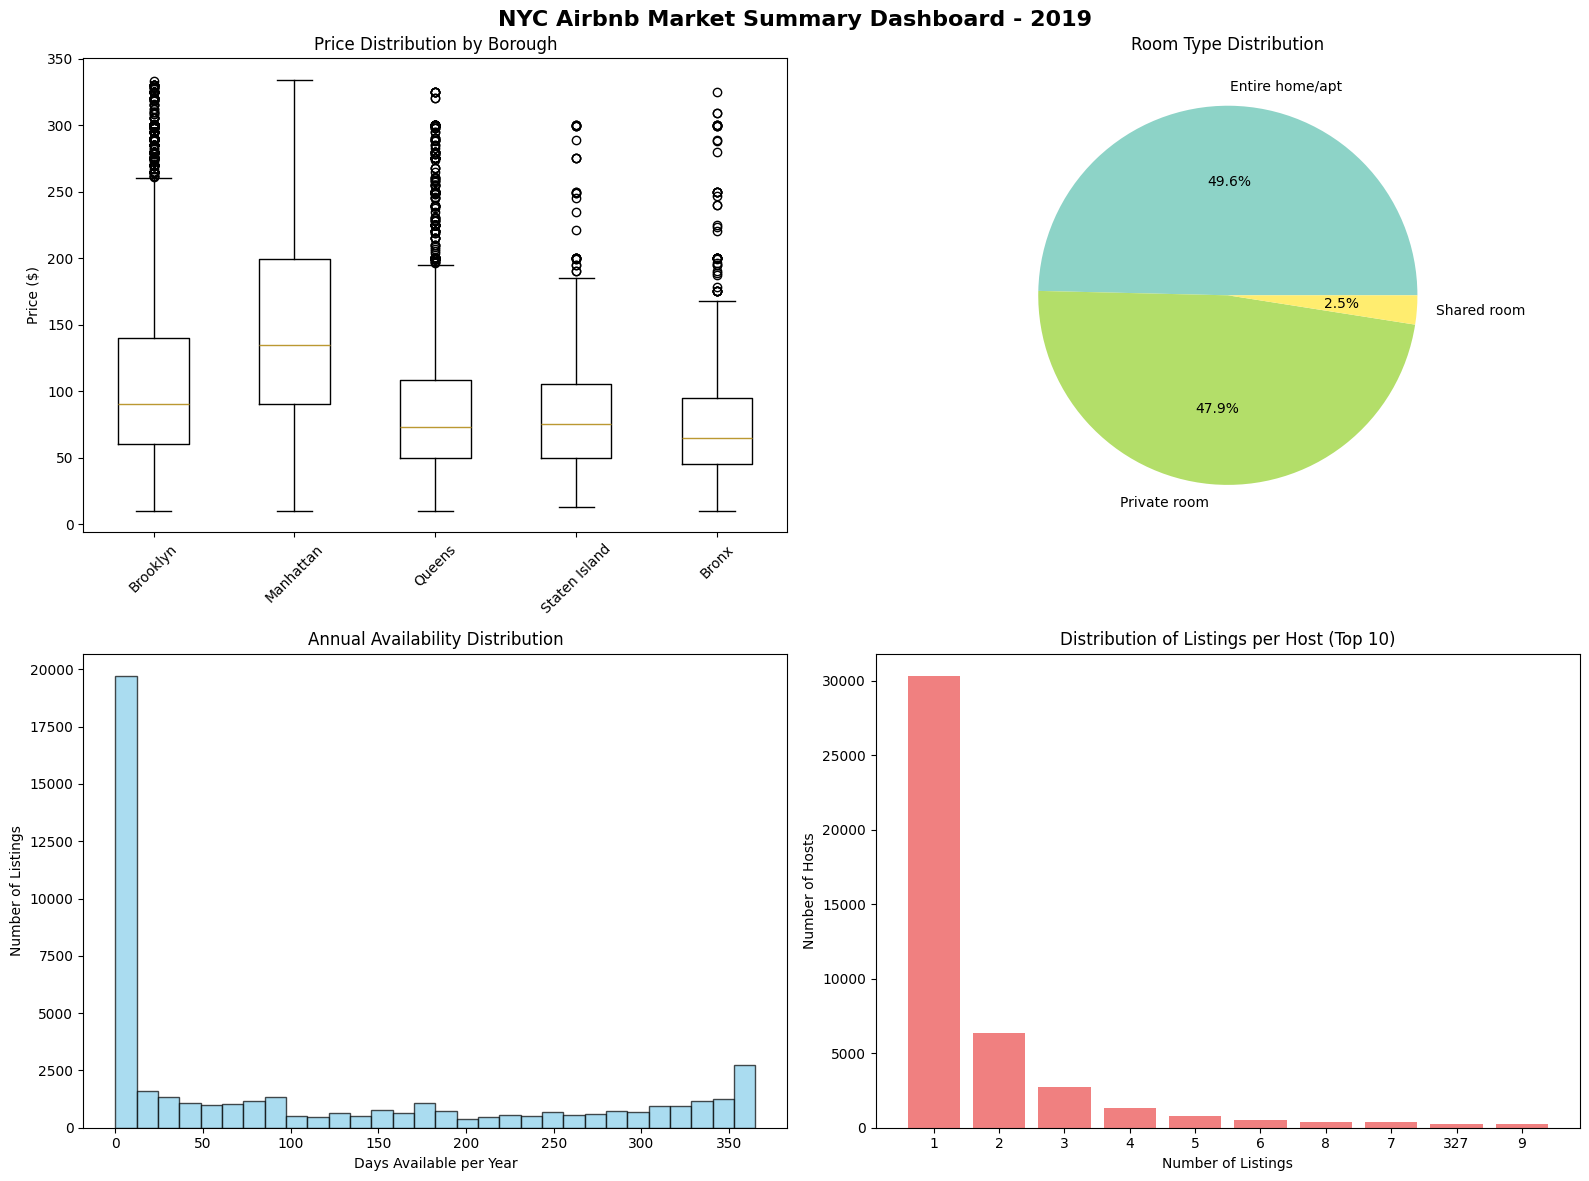


 KEY RECOMMENDATIONS
──────────────────────────────
1. Focus on Manhattan & Brooklyn for premium pricing opportunities
2. 'Entire home/apt' listings command highest prices but have more competition
3. Multi-property hosts show different pricing strategies - analyze for optimization
4. Low availability often correlates with higher demand - consider dynamic pricing
5. Review frequency is a key success indicator - focus on guest experience
6. Geographic location significantly impacts pricing - micro-location matters

 BUSINESS OPPORTUNITIES
──────────────────────────────
• Under-served neighborhoods with high demand but low supply
• Optimize pricing based on room type and location
• Seasonal pricing strategies based on availability patterns
• Host education programs for pricing optimization
• Market expansion in boroughs with lower competition

 ANALYSIS COMPLETED SUCCESSFULLY!
Dataset: 45,899 listings analyzed
Time period: 2019 NYC Airbnb market
Quality: Data cleaned and outliers handle

In [ ]:
print("EXECUTIVE SUMMARY DASHBOARD")
print("="*70)

# Key Performance Indicators
total_listings = len(data_no_outliers)
total_hosts = data_no_outliers['host_id'].nunique()
avg_price = data_no_outliers['price'].mean()
median_price = data_no_outliers['price'].median()
avg_availability = data_no_outliers['availability_365'].mean()
total_neighborhoods = data_no_outliers['neighbourhood'].nunique()

print(f" MARKET OVERVIEW")
print(f"{'─' * 30}")
print(f"Total Active Listings: {total_listings:,}")
print(f"Total Unique Hosts: {total_hosts:,}")
print(f"Average Listings per Host: {total_listings/total_hosts:.1f}")
print(f"Total Neighborhoods: {total_neighborhoods}")
print(f"Boroughs Covered: {data_no_outliers['neighbourhood_group'].nunique()}")

print(f"\n PRICING INSIGHTS")
print(f"{'─' * 30}")
print(f"Average Price: ${avg_price:.2f}")
print(f"Median Price: ${median_price:.2f}")
print(f"Price Range: ${data_no_outliers['price'].min():.0f} - ${data_no_outliers['price'].max():.0f}")
print(f"Most Expensive Borough: {data_no_outliers.groupby('neighbourhood_group')['price'].mean().idxmax()}")
print(f"Most Affordable Borough: {data_no_outliers.groupby('neighbourhood_group')['price'].mean().idxmin()}")

print(f"\n AVAILABILITY INSIGHTS")
print(f"{'─' * 30}")
print(f"Average Annual Availability: {avg_availability:.0f} days")
print(f"Fully Booked Listings: {(data_no_outliers['availability_365'] == 0).sum():,}")
print(f"Always Available Listings: {(data_no_outliers['availability_365'] == 365).sum():,}")
print(f"Average Occupancy Rate: {((365 - avg_availability) / 365 * 100):.1f}%")

print(f"\n ROOM TYPE BREAKDOWN")
print(f"{'─' * 30}")
room_breakdown = data_no_outliers['room_type'].value_counts()
for room_type, count in room_breakdown.items():
    percentage = (count / total_listings) * 100
    avg_price_room = data_no_outliers[data_no_outliers['room_type'] == room_type]['price'].mean()
    print(f"{room_type}: {count:,} ({percentage:.1f}%) - Avg: ${avg_price_room:.0f}")

print(f"\n REVIEW INSIGHTS")
print(f"{'─' * 30}")
total_reviews = data_no_outliers['number_of_reviews'].sum()
avg_reviews_per_listing = data_no_outliers['number_of_reviews'].mean()
listings_with_reviews = (data_no_outliers['number_of_reviews'] > 0).sum()

print(f"Total Reviews: {total_reviews:,}")
print(f"Average Reviews per Listing: {avg_reviews_per_listing:.1f}")
print(f"Listings with Reviews: {listings_with_reviews:,} ({(listings_with_reviews/total_listings*100):.1f}%)")
print(f"New Listings (0 reviews): {total_listings - listings_with_reviews:,}")

# Create a final summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NYC Airbnb Market Summary Dashboard - 2019', fontsize=16, fontweight='bold')

# 1. Price distribution by borough
borough_price_data = [data_no_outliers[data_no_outliers['neighbourhood_group'] == borough]['price'].values
                     for borough in data_no_outliers['neighbourhood_group'].unique()]
ax1.boxplot(borough_price_data, labels=data_no_outliers['neighbourhood_group'].unique())
ax1.set_title('Price Distribution by Borough')
ax1.set_ylabel('Price ($)')
ax1.tick_params(axis='x', rotation=45)

# 2. Room type distribution
room_counts = data_no_outliers['room_type'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(room_counts)))
ax2.pie(room_counts.values, labels=room_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Room Type Distribution')

# 3. Availability patterns
ax3.hist(data_no_outliers['availability_365'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_title('Annual Availability Distribution')
ax3.set_xlabel('Days Available per Year')
ax3.set_ylabel('Number of Listings')

# 4. Host listing distribution
host_counts = data_no_outliers['calculated_host_listings_count'].value_counts().head(10)
ax4.bar(range(len(host_counts)), host_counts.values, color='lightcoral')
ax4.set_title('Distribution of Listings per Host (Top 10)')
ax4.set_xlabel('Number of Listings')
ax4.set_ylabel('Number of Hosts')
ax4.set_xticks(range(len(host_counts)))
ax4.set_xticklabels(host_counts.index)

plt.tight_layout()
plt.show()

print(f"\n KEY RECOMMENDATIONS")
print(f"{'─' * 30}")
print("1. Focus on Manhattan & Brooklyn for premium pricing opportunities")
print("2. 'Entire home/apt' listings command highest prices but have more competition")
print("3. Multi-property hosts show different pricing strategies - analyze for optimization")
print("4. Low availability often correlates with higher demand - consider dynamic pricing")
print("5. Review frequency is a key success indicator - focus on guest experience")
print("6. Geographic location significantly impacts pricing - micro-location matters")

print(f"\n BUSINESS OPPORTUNITIES")
print(f"{'─' * 30}")
print("• Under-served neighborhoods with high demand but low supply")
print("• Optimize pricing based on room type and location")
print("• Seasonal pricing strategies based on availability patterns")
print("• Host education programs for pricing optimization")
print("• Market expansion in boroughs with lower competition")

print(f"\n ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"Dataset: {total_listings:,} listings analyzed")
print(f"Time period: 2019 NYC Airbnb market")
print(f"Quality: Data cleaned and outliers handled")
print("="*70)